In [312]:
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from datetime import datetime
from sklearn.model_selection import GridSearchCV

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Fire Emblem Heroes: Predicting Tiers for Current and New Characters

For many people who play gacha games, there comes a time where the player accumulates a boatload amount of items (for this game: orbs) that can be used to roll for characters. For those who are FTP (free to play), every orb is precious, because accumulating enough to roll, let alone to accumulate enough to have a shot at a character that they want, takes time

Most players are influenced by two factors when rolling for characters: whether they like the character, and whether the character is good in the game.

Because the first factor is purely subjective, we would like to address the second factor: What makes a character good? A place that I often look to when trying to see how good a character is, is Gamepress.gg, particularly the [tier list](https://gamepress.gg/feheroes/offense-tier-list).

In this notebook, we will go through the process of creating a model to predict what tier characters fall under. This will help give us a better idea of whether a character is "good" or not.

To start we will load the dataset we scraped previously (refer to the Fire Emblem Heroes Scraping and Visualization Notebook to see process)

In [3]:
#tiers = pd.read_excel("tier_list_110719.xlsx")
heroes = pd.read_excel("hero_data_5_20.xlsx")

In [4]:
heroes.head()

,Name,Tier,Color,Weapon,MoveCode,Rarities,HP,Atk,Spd,Def,...,Refines,Personal Weapon,Legendary/Mythic,Origin,Duo,Image,Movement,Refresher,Stars,Obtain
0,Sharena,Tier 5,Blue,Lance,331,4_Star_Story,43,32,32,29,...,True,True,False,Fire Emblem Heroes,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,['4'],Story
1,Lugh,Tier 3,Green,Tome,331,stars-5-Star,37,35,36,17,...,True,False,False,Fire Emblem: The Binding Blade,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,['5'],NaN
2,Legendary Roy,Tier 2,Red,Sword,331,stars-5-Star,39,34,38,32,...,False,True,True,Fire Emblem Heroes,False,https://gamepress.gg/feheroes/sites/fireemblem...,Infantry,False,['5'],NaN
3,Panne,Tier 3,Blue,Beast,306,3-4_Grand_Hero_Battle,41,29,34,30,...,False,True,False,Fire Emblem: Awakening,False,https://gamepress.gg/feheroes/sites/fireemblem...,Cavalry,False,"['3', '4']",GHB
4,Selkie,Tier 3,Blue,Beast,306,stars-5-Star,35,29,38,19,...,False,True,False,Fire Emblem Fates,False,https://gamepress.gg/feheroes/sites/fireemblem...,Cavalry,False,['5'],NaN


## Feature Extraction

Now that we have our data, let's make the most of it. It is an important skill to be able to garner as much "useful" information from a dataset as possible, as well as making it easy for your model to use.

### Seasonal Banners

We notice that, looking at the characters, that there are a good number of seasonal banners that bring with them limitedly-available characters. For collectors, these would be banners that they would dump orbs on. But it's possible that some seasons are superior to others in terms of characters.

In [5]:
def seasonal_label(row):
    if row["Name"].startswith("Summer"):
        return "Summer"
    elif row["Name"].startswith("Spring"):
        return "Spring"
    elif row["Name"].startswith("Halloween"):
        return "Halloween"
    elif row["Name"].startswith("Winter"):
        return "Winter"
    elif row["Name"].startswith("Brave"):
        return "Brave"
    elif row["Name"].startswith("New Year"):
        return "New Year"
    elif (row["Name"].startswith("Bridal") or row["Name"].startswith("Groom")):
        return "Bridal"
    elif row["Name"].startswith("Valentine"):
        return "Valentine"
    else:
        return None

In [6]:
heroes["Special Banner"] = heroes.apply(lambda row: seasonal_label(row), axis=1)

### Rarities

We will also separate the information related to the rarity of a character into different columns

In [7]:
rare3 = []
rare4 = []
rare5 = []
for rare in heroes["Stars"]:
    if '3' in rare:
        rare3.append(1)
    else:
        rare3.append(0)
    if '4' in rare:
        rare4.append(1)
    else:
        rare4.append(0)
    if '5' in rare:
        rare5.append(1)
    else:
        rare5.append(0)

heroes["3-star"] = rare3
heroes["4-star"] = rare4
heroes["5-star"] = rare5

## Exploratory Data Analysis

Before we begin looking into building a model, let's look into our features.

The feature of most importance to us here is the __Tier__ feature. So our exploration will be focused on the comparison of our other features to Tier placement.

### Stats of Characters by Tier

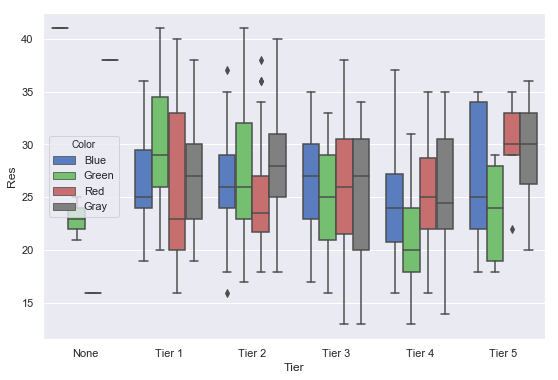

In [292]:
stat = "Res"

sns.set()
sns.set_color_codes("muted")
plt.figure(figsize = (9, 6))
my_pal = {"Blue": "b", "Green": "g", 'Red':"r", "Gray": "gray"}

b = sns.boxplot(x="Tier", y=stat, hue="Color",
                 data=heroes, palette=my_pal, order=['None', 'Tier 1', "Tier 2", "Tier 3", "Tier 4", 'Tier 5'])
plt.show()

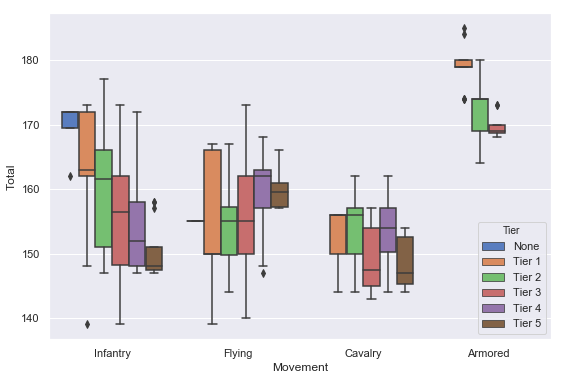

In [308]:
stat2 = "Total"

plt.figure(figsize = (9, 6))
b = sns.boxplot(x="Movement", y=stat2, hue="Tier",
                 data=heroes.sort_values("Tier"), palette='muted')
plt.show()

### Qualities of Characters by Tier

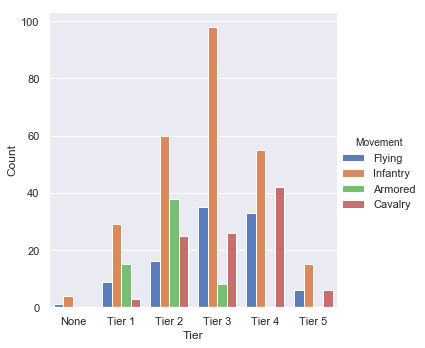

In [309]:
move_tiers = heroes.groupby(by = ["Tier", "Movement"]).agg({"Name": "count"})
move_tiers = move_tiers["Name"].reset_index()
move_tiers["Count"] = move_tiers["Name"]

b = sns.catplot(x="Tier", y="Count", hue="Movement",
                 data=move_tiers, kind = "bar", palette='muted')
plt.show()

In [276]:
tiers = heroes[heroes["Tier"] != "None"].groupby(by = ["Tier", "Color"]).agg({"Name": "count", 
            "HP": "mean", "Atk": "mean", "Spd": "mean", "Def": "mean", "Res": "mean",
            "Refines": "sum", "Personal Weapon": "sum", "Legendary/Mythic": "sum", 
            "Duo": "sum", "Refresher": "sum", "3-star": "sum", "4-star": "sum", 
            "5-star": "sum"})

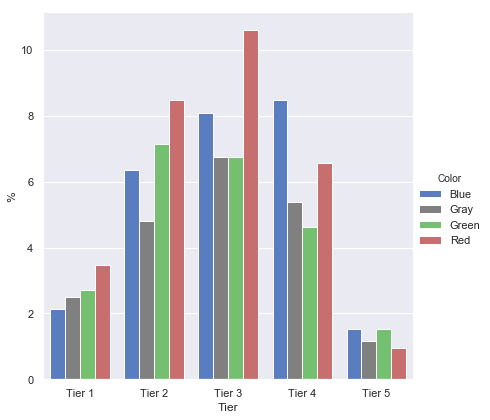

In [264]:
ti = tiers["Name"].reset_index()

ti["%"] = ti["Name"] / sum(ti["Name"]) * 100

g = sns.catplot(x="Tier", y="%", hue="Color", data=ti, 
                height=6, kind="bar", palette=my_pal)

From here, we can see the distribution of all the characters, and what tier they fall in. It is a fairly normal distribution on all counts (by color and by count in general), though Tier 5 is noticeably smaller than even Tier 1.

Number of Refreshers: 29.0


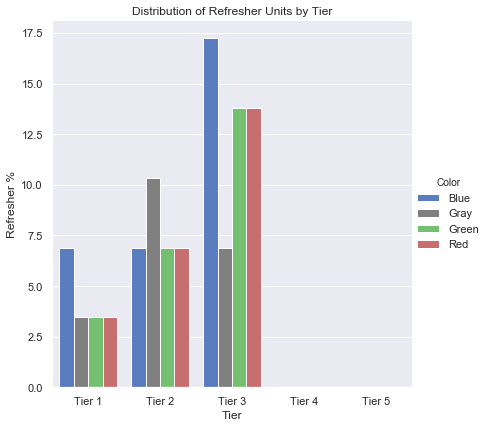

In [311]:
ref = tiers["Refresher"].reset_index()
ref["Refresher %"] = ref["Refresher"] / sum(ref["Refresher"]) * 100
print("Number of Refreshers:", sum(ref["Refresher"]))

g = sns.catplot(x="Tier", y="Refresher %", hue="Color", data=ref, 
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Refresher Units by Tier")
plt.show()

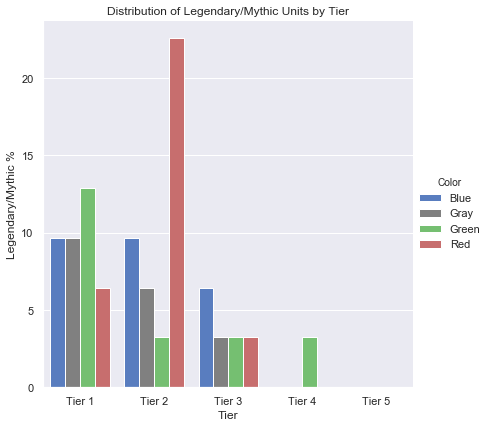

In [266]:
leg = tiers["Legendary/Mythic"].reset_index()
leg["Legendary/Mythic %"] = leg["Legendary/Mythic"] / sum(leg["Legendary/Mythic"]) * 100

g = sns.catplot(x="Tier", y="Legendary/Mythic %", hue="Color", data=leg,
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Legendary/Mythic Units by Tier")
plt.show()

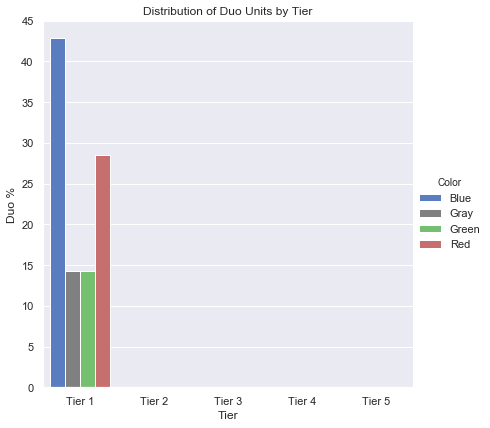

In [267]:
duo = tiers["Duo"].reset_index()
duo["Duo %"] = duo["Duo"] / sum(duo["Duo"]) * 100

g = sns.catplot(x="Tier", y="Duo %", hue="Color", data=duo,
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Duo Units by Tier")
plt.show()

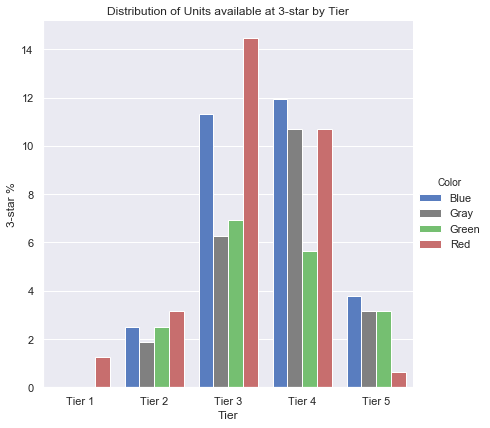

In [268]:
three = tiers["3-star"].reset_index()
three["3-star %"] = three["3-star"] / sum(three["3-star"]) * 100

g = sns.catplot(x="Tier", y="3-star %", hue="Color", data=three,
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Units available at 3-star by Tier")
plt.show()

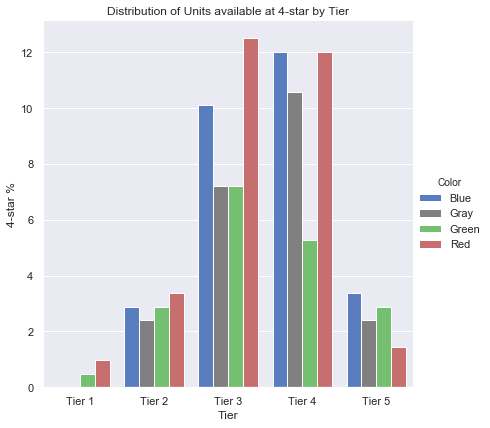

In [269]:
four = tiers["4-star"].reset_index()
four["4-star %"] = four["4-star"] / sum(four["4-star"]) * 100

g = sns.catplot(x="Tier", y="4-star %", hue="Color", data=four,
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Units available at 4-star by Tier")
plt.show()

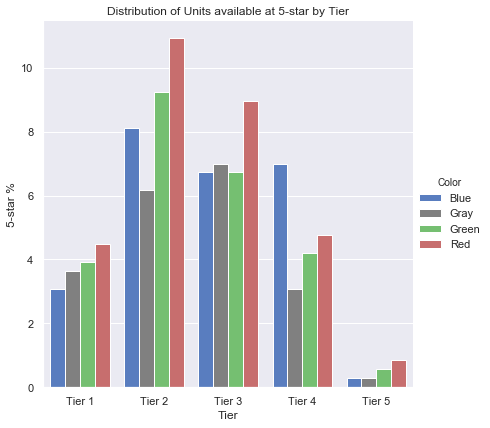

In [270]:
five = tiers["5-star"].reset_index()
five["5-star %"] = five["5-star"] / sum(five["5-star"]) * 100

g = sns.catplot(x="Tier", y="5-star %", hue="Color", data=five,
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Units available at 5-star by Tier")
plt.show()

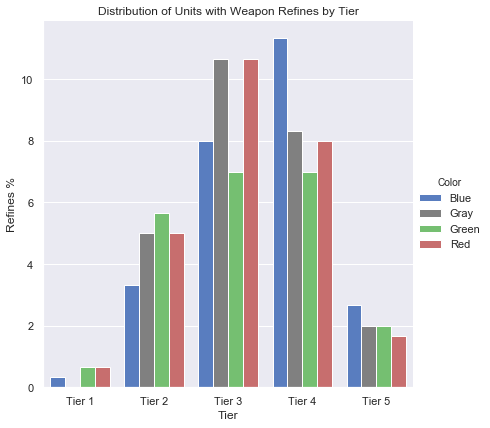

In [271]:
refine = tiers["Refines"].reset_index()
refine["Refines %"] = refine["Refines"] / sum(refine["Refines"]) * 100

g = sns.catplot(x="Tier", y="Refines %", hue="Color", data=refine,
                height=6, kind="bar", palette=my_pal)
plt.title("Distribution of Units with Weapon Refines by Tier")
plt.show()

## Feature Engineering

### One-Hot Encoding and Selecting Our Features

An important thing to deal with before feeding your data into your model is to think about how the model takes in the data. To help with the model's prediction, we will take the categorical variables and go through a process called "one-hot encoding", which takes each value in a categorial variable and makes a new variable that indicates whether the character has that attribute or not. 

We can see that doing this will noticeably increase the number of variables for our model.

In [97]:
data = pd.get_dummies(heroes, prefix = ["Obtain", "Legendary/Mythic", "Duo", "Color", "Weapon", "Move", 
                         "Refresher", "Refines", "Special Banner", "Personal"], 
               columns = ["Obtain", "Legendary/Mythic", "Duo", "Color", "Weapon", "Movement",
                         "Refresher", "Refines", "Special Banner", "Personal Weapon"])

#with pd.option_context('display.max_rows', 5, 'display.max_columns', 100):
#    display(data)

In [98]:
print("Number of Features in Original Data Set", len(pd.read_excel("hero_data.xlsx").columns))
print("Number of Features in Updated Data Set", len(data.columns))

Number of Features in Original Data Set 19
Number of Features in Updated Data Set 55


In [284]:
tiers_perc = tiers.copy()

tiers_perc["Refines"] = tiers_perc["Refines"] / tiers_perc["Name"] * 100
tiers_perc["Personal Weapon"] = tiers_perc["Personal Weapon"] / tiers_perc["Name"] * 100
tiers_perc["Legendary/Mythic"] = tiers_perc["Legendary/Mythic"] / tiers_perc["Name"] * 100
tiers_perc["Duo"] = tiers_perc["Duo"] / tiers_perc["Name"] * 100
tiers_perc["Refresher"] = tiers_perc["Refresher"] / tiers_perc["Name"] * 100
tiers_perc["3-star"] = tiers_perc["3-star"] / tiers_perc["Name"] * 100
tiers_perc["4-star"] = tiers_perc["4-star"] / tiers_perc["Name"] * 100
tiers_perc["5-star"] = tiers_perc["5-star"] / tiers_perc["Name"] * 100
# change stat averages to percentile compared to the max
tiers_perc["HP"] = tiers_perc["HP"] / max(heroes["HP"]) * 100
tiers_perc["Atk"] = tiers_perc["Atk"] / max(heroes["Atk"]) * 100
tiers_perc["Spd"] = tiers_perc["Spd"] / max(heroes["Spd"]) * 100
tiers_perc["Def"] = tiers_perc["Def"] / max(heroes["Def"]) * 100
tiers_perc["Res"] = tiers_perc["Res"] / max(heroes["Res"]) * 100
tiers_perc = tiers_perc.drop("Name", axis = 1)

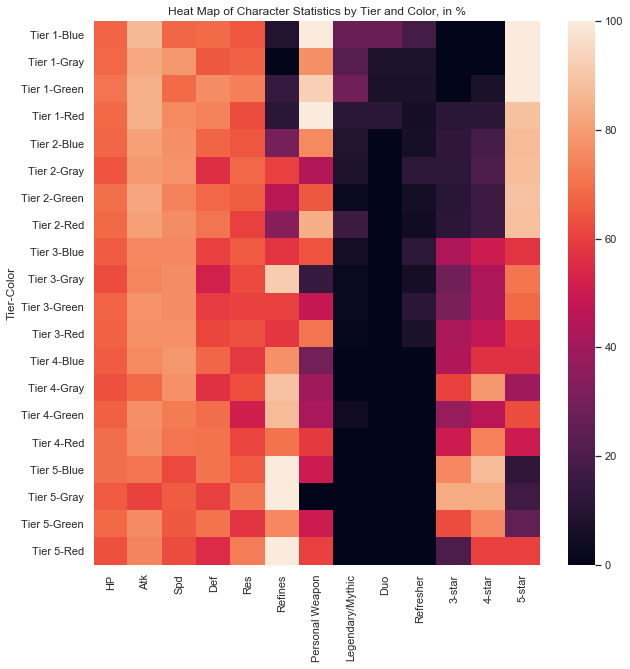

In [287]:
#t_heroes = heroes.set_index("Tier")
#t_heroes = t_heroes.drop("MoveCode", axis = 1)
#t_heroes._get_numeric_data()

plt.figure(figsize = (10, 10))
plt.title("Heat Map of Character Statistics by Tier and Color, in %")
sns.heatmap(tiers_perc)
plt.show()

For this next step, we will choose which variables to feed to our model. For the time being, we will choose to exclude features that are mostly redundant, as well as the origin of the characters.

In [99]:
data2 = data
data2 = data2.drop(["Origin", "MoveCode", "Image", "Rarities", "Personal_False", "Refines_False", "Duo_False",
                   "Legendary/Mythic_False", "Stars", "Refresher_False"], axis = 1)

## Model Testing

At this point, now that we have decided on our features, we will begin to train the model. We will begin by randomizing our data so that ordering by name does not confound the results of our model.

Before we begin selecting a model, we need to understand the type of problem that we are trying to solve. This problem is a **Multi-classification problem**, where we are trying to classify characters into more than two classes. In our case, we are trying to classify our characters into five "categories", which are our tiers.

We will also need to remove the characters that do not have a labeled tier.

Afterwards, we will split the data into two parts: training and testing data. We do a ~80/20 split.

In [100]:
data2[data2["Tier"] == "None"]

,Name,Tier,HP,Atk,Spd,Def,Res,Total,3-star,4-star,...,Refines_True,Special Banner_Brave,Special Banner_Bridal,Special Banner_Halloween,Special Banner_New Year,Special Banner_Spring,Special Banner_Summer,Special Banner_Valentine,Special Banner_Winter,Personal_True
176,Bridal Nailah,None,40,35,41,31,25,172,0,0,...,0,0,1,0,0,0,0,0,0,1
177,Bridal Oboro,None,42,39,35,40,16,172,0,0,...,1,0,1,0,0,0,0,0,0,0
178,Groom Rafiel,None,38,28,35,20,41,162,0,1,...,0,0,1,0,0,0,0,0,0,1
179,Bridal Micaiah,None,39,39,20,19,38,155,0,0,...,0,0,1,0,0,0,0,0,0,1
523,Groom Hinata,None,47,37,27,40,21,172,0,1,...,1,0,1,0,0,0,0,0,0,0


In [101]:
totest = data2[data2["Tier"] == "None"]
data3 = data2[data2["Tier"] != "None"].sample(frac=1)
data3 = data3.set_index("Name")

In [102]:
train = data3[:405]
test = data3[405:]

In [103]:
train_y = train["Tier"]
train_x = train.drop(["Tier"], axis = 1)
test_y = test["Tier"]
test_x = test.drop(["Tier"], axis = 1)

For the choice of our model, we have many options that we can go with. To begin our analysis, we will use the DecisionTreeClassifier model.

In [214]:
clf = DecisionTreeClassifier()
clf.fit(train_x, train_y)
score = clf.score(test_x, test_y)
print("Train Score:", clf.score(train_x, train_y))
print("Test Score:", score)

Train Score: 1.0
Test Score: 0.42105263157894735


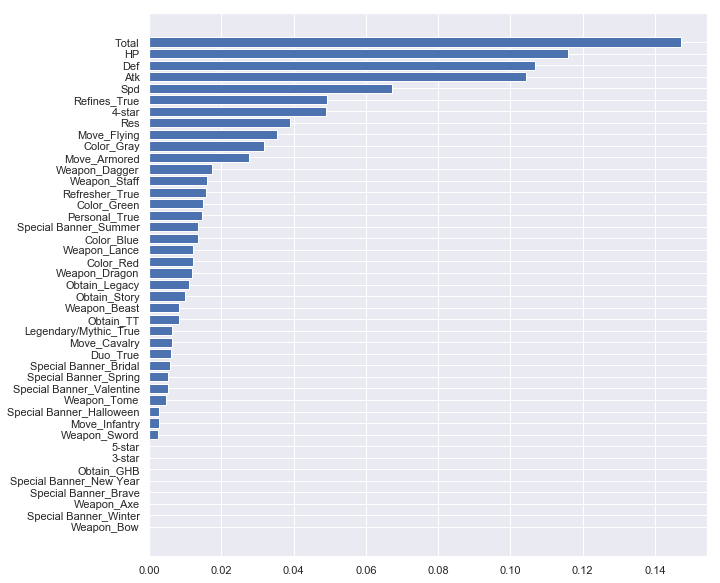

In [215]:
# allows one to see the impact each variable has on the model's prediction
importances = clf.feature_importances_

sorted_index = np.argsort(importances)

# Create labels
labels = train_x.columns[sorted_index]


# Create plot
plt.figure(figsize = (10, 10))
plt.barh(range(train_x.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

In [110]:
def get_heatmap(model, features, label):
    pred = {'y_Predicted': model.predict(features),
        'y_Actual': label.values
        }
    pred_df = pd.DataFrame(pred, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(pred_df['y_Actual'], pred_df['y_Predicted'], 
                                rownames=['Actual'], colnames=['Predicted'], margins = True)

    sns.heatmap(confusion_matrix, annot=True, fmt='g')
    plt.title("Training Data Heatmap")
    plt.show()

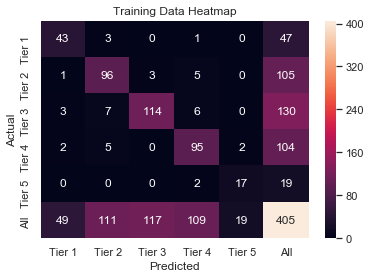

In [111]:
get_heatmap(clf, train_x, train_y)

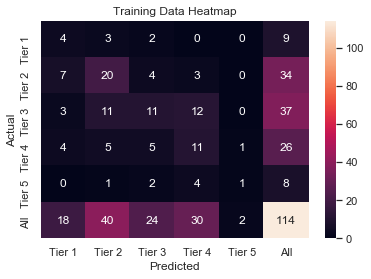

In [112]:
get_heatmap(clf, test_x, test_y)

## What Could We Do Better?

From the initial results above, we can see that our model does a decent job at predicting the tier that a character will be in. However, there are still ways that we could improve our model's capacity to predict how good a character is deemed.

(Granted, Tier lists are somewhat subjective. Thus, it is possible that what a model believes to be a "Tier 1" character doesn't align with the tier-list maker's views. Also, as of now, there is information that may be lacking)

### Rescaling Data

One avenue to look at is with the way our data is fed into the model. Some models are sensitive to feature scaling. To avoid this issue, there are two common ways to adjust the quantitative values of our data.

#### Normalization

Normalization is the process of scaling a variable to have values between 0 and 1

In [114]:
from sklearn import preprocessing

In [216]:
norm = data3.copy()
scale_cols = ["HP", "Atk", "Spd", "Def", "Res", "Total"]
normed = preprocessing.normalize(norm[scale_cols])

norm[scale_cols] = normed

ntrain = norm[:405]
ntest = norm[405:]
ntrain_y = ntrain["Tier"]
ntrain_x = ntrain.drop(["Tier"], axis = 1)
ntest_y = ntest["Tier"]
ntest_x = ntest.drop(["Tier"], axis = 1)


nclf = DecisionTreeClassifier()
nclf.fit(ntrain_x, ntrain_y)
nscore = nclf.score(ntest_x, ntest_y)
print("Train Score:", nclf.score(ntrain_x, ntrain_y))
print("Test Score:", nscore)

Train Score: 1.0
Test Score: 0.37719298245614036


In [116]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(ntrain_x, ntrain_y)
kscore = neigh.score(ntest_x, ntest_y)
print("Train Score:", neigh.score(ntrain_x, ntrain_y))
print("Test Score:", kscore)

Train Score: 0.5530864197530864
Test Score: 0.42105263157894735


#### Standardization

Meanwhile, standardization is the process of scaling values to have a mean of 0 and a standard deviation of 1.

In [217]:
stan = data3.copy()
scale_cols = ["HP", "Atk", "Spd", "Def", "Res", "Total"]
staned = preprocessing.scale(stan[scale_cols])

stan[scale_cols] = staned

strain = stan[:405]
stest = stan[405:]
strain_y = strain["Tier"]
strain_x = strain.drop(["Tier"], axis = 1)
stest_y = stest["Tier"]
stest_x = stest.drop(["Tier"], axis = 1)


sclf = DecisionTreeClassifier()
sclf.fit(strain_x, strain_y)
sscore = sclf.score(stest_x, stest_y)
print("Train Score:", sclf.score(strain_x, strain_y))
print("Test Score:", sscore)

Train Score: 1.0
Test Score: 0.3684210526315789


In [118]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [119]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(strain_x, strain_y)
gscore = gpc.score(stest_x, stest_y)
print("Train Score:", gpc.score(strain_x, strain_y))
print("Test Score:", gscore)

Train Score: 0.4222222222222222
Test Score: 0.3508771929824561


In [120]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(strain_x, strain_y)
gascore = gauss.score(stest_x, stest_y)
print("Train Score:", gauss.score(strain_x, strain_y))
print("Test Score:", gascore)

Train Score: 0.28641975308641976
Test Score: 0.2543859649122807


For our intents and purposes, we will be using the standardized set of numeric values moving forward. 

### Stochastic Gradient Descent

In [121]:
from sklearn.linear_model import SGDClassifier

sgdclf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500)
sgdclf.fit(train_x, train_y)
sgdscore = sgdclf.score(test_x, test_y)
print("Train Score:", sgdclf.score(train_x, train_y))
print("Test Score:", sgdscore)

Train Score: 0.38765432098765434
Test Score: 0.47368421052631576


In [122]:
n_sgdclf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500)
n_sgdclf.fit(ntrain_x, ntrain_y)
n_sgdscore = n_sgdclf.score(ntest_x, ntest_y)
print("Train Score:", n_sgdclf.score(ntrain_x, ntrain_y))
print("Test Score:", n_sgdscore)

Train Score: 0.5679012345679012
Test Score: 0.5263157894736842


In [123]:
s_sgdclf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=500)
s_sgdclf.fit(strain_x, strain_y)
s_sgdscore = s_sgdclf.score(stest_x, stest_y)
print("Train Score:", s_sgdclf.score(strain_x, strain_y))
print("Test Score:", s_sgdscore)

Train Score: 0.5777777777777777
Test Score: 0.42105263157894735


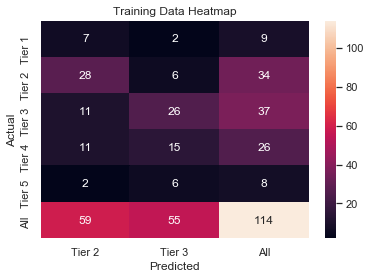

In [124]:
get_heatmap(sgdclf, test_x, test_y)

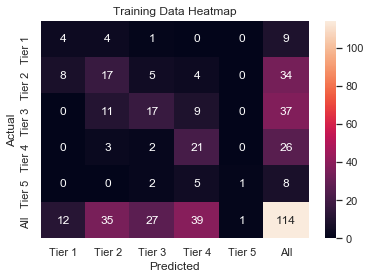

In [125]:
get_heatmap(n_sgdclf, ntest_x, ntest_y)

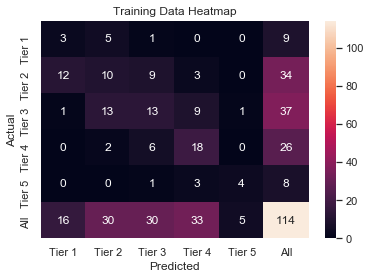

In [126]:
get_heatmap(s_sgdclf, stest_x, stest_y)

### Support Vector Machine (SVM)

In [163]:
from sklearn import svm
nsvma = svm.SVC(C = 4.5, gamma='scale', kernel = "linear", degree = 3)
nsvma.fit(ntrain_x, ntrain_y)
nsvm_score = nsvma.score(ntest_x, ntest_y)
print("Train Score:", nsvma.score(ntrain_x, ntrain_y))
print("Test Score:", nsvm_score)

Train Score: 0.6246913580246913
Test Score: 0.42105263157894735


In [178]:
svma = svm.SVC(C = 4.5, gamma='scale', kernel = "linear", degree = 3)
svma.fit(strain_x, strain_y)
svm_score = svma.score(stest_x, stest_y)
print("Train Score:", svma.score(strain_x, strain_y))
print("Test Score:", svm_score)

Train Score: 0.7234567901234568
Test Score: 0.5263157894736842


In [160]:
lsvma = svm.LinearSVC(penalty = 'l2', C = 2, class_weight = "balanced")
lsvma.fit(strain_x, strain_y)
lsvm_score = lsvma.score(stest_x, stest_y)
print("Train Score:", lsvma.score(strain_x, strain_y))
print("Test Score:", lsvm_score)

Train Score: 0.6592592592592592
Test Score: 0.5614035087719298


/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


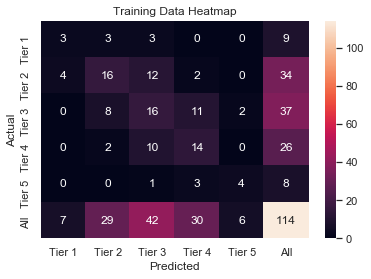

In [133]:
get_heatmap(svma, stest_x, stest_y)

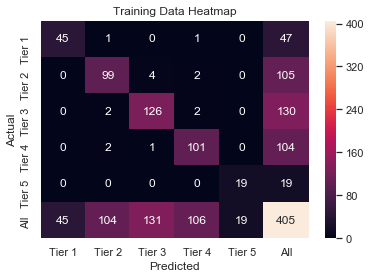

In [134]:
get_heatmap(svma, strain_x, strain_y)

### Grid Search for Best Parameters

In [142]:
parameters = {'max_depth': range(1, 16)}
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, parameters)
clf.fit(strain_x, strain_y)
print(clf.best_params_)
score = clf.score(stest_x, stest_y)
print("Train Score:", clf.score(strain_x, strain_y))
print("Test Score:", score)

{'max_depth': 6}
Train Score: 0.7308641975308642
Test Score: 0.43859649122807015


In [176]:
params = {"C": [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4, 4.5, 5, 5.5, 6], "gamma": ['scale'], "kernel": 
          ['linear', 'poly'], "degree": [2, 3, 4, 5, 6, 7, 8]}
svc = svm.SVC()
svmag = GridSearchCV(svc, params)
svmag.fit(strain_x, strain_y)
svm_score = svmag.score(stest_x, stest_y)
print("Train Score:", svmag.score(strain_x, strain_y))
print("Test Score:", svm_score)
svmag.best_params_

Train Score: 0.8962962962962963
Test Score: 0.4824561403508772


{'C': 2.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

### Imbalanced Classes

Now that we've covered some of the more general practices, we can look at an approach that applies to our specific problem. When looking at our values for classification, it is important to note the "balance" of our classes.

In [216]:
data3.groupby("Tier").size()

Tier
Tier 1     56
Tier 2    139
Tier 3    167
Tier 4    130
Tier 5     27
dtype: int64

In [221]:
data3.groupby("Tier").size() * 100 / len(data3)

Tier
Tier 1    10.789981
Tier 2    26.782274
Tier 3    32.177264
Tier 4    25.048170
Tier 5     5.202312
dtype: float64

Looking at the cell above, we see that there is an imbalance particularly at the ends of our tiers. In a balanced situation, each tier should be ~20% of the total count. However, tiers 1 and 5 combined accounted for only about 16% of the total, with Tier 5 only accounting for ~5%.

There are different approaches that we can take to tackle this. Two common ones include:

* Under-sample: remove samples from over-represented classes
* Over-sample: add more samples from under-represented classes

Because our dataset isn't that big, the first approach isn't that viable. For our circumstances, we will go with an over-sampling method, particularly __SMOTE (Synthetic Minority Over-sampling Technique)__ 

In [146]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [180]:
smote = SMOTE({"Tier 1": 100, "Tier 5":100})

sm_train_x, sm_train_y = smote.fit_sample(strain_x, strain_y)
print(sm_train_x.shape, sm_train_y.shape)

(539, 43) (539,)


In [181]:
len(strain_x)

405

In [182]:
svma_smote = svm.SVC(C = 2, gamma='scale', kernel = "poly", degree = 3)
svma_smote.fit(sm_train_x, sm_train_y)
svm_smote_score = svma_smote.score(stest_x, stest_y)
print("Train Score:", svma_smote.score(sm_train_x, sm_train_y))
print("Test Score:", svm_smote_score)

Train Score: 0.9239332096474954
Test Score: 0.5


In [195]:
from sklearn.ensemble import RandomForestClassifier

smote_rfc = RandomForestClassifier(max_depth=7, class_weight = "balanced")
smote_rfc.fit(sm_train_x, sm_train_y)
rfc_smote_score = smote_rfc.score(stest_x, stest_y)
print("Train Score:", smote_rfc.score(sm_train_x, sm_train_y))
print("Test Score:", rfc_smote_score)

Train Score: 0.9072356215213359
Test Score: 0.49122807017543857


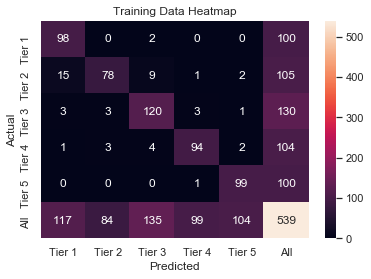

In [196]:
get_heatmap(smote_rfc, sm_train_x, sm_train_y)

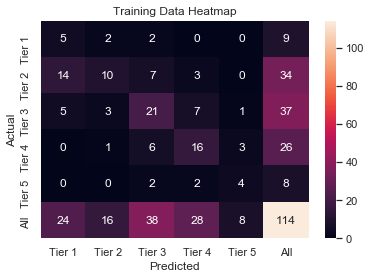

In [197]:
get_heatmap(smote_rfc, stest_x, stest_y)

### Looking at Precision/Recall Scores

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [200]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

y_pred = smote_rfc.predict(stest_x)
prec = precision_score(stest_y, y_pred, average = None)
recall = recall_score(stest_y, y_pred, average = None)

y = 0
for tier in ["Tier 1", "Tier 2", "Tier 3", "Tier 4", "Tier 5"]:
    print(tier)
    print("Precision Score:", prec[y])
    print("Recall Score:", recall[y])
    print("")
    y += 1

Tier 1
Precision Score: 0.20833333333333334
Recall Score: 0.5555555555555556

Tier 2
Precision Score: 0.625
Recall Score: 0.29411764705882354

Tier 3
Precision Score: 0.5526315789473685
Recall Score: 0.5675675675675675

Tier 4
Precision Score: 0.5714285714285714
Recall Score: 0.6153846153846154

Tier 5
Precision Score: 0.5
Recall Score: 0.5



In [211]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

random_state = np.random.RandomState(0)
classes=["Tier 1", "Tier 2", "Tier 3", "Tier 4", "Tier 5"]

# Use label_binarize to be multi-label like settings
Y = label_binarize(stan["Tier"], classes=classes)
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = sm_train_x, stest_x, sm_train_y, stest_y
Y_train = label_binarize(Y_train, classes=classes)
Y_test = label_binarize(Y_test, classes=classes)

#train_test_split(stan.drop(["Tier"], axis = 1), Y, test_size=.2,
#                                                    random_state=random_state)

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state, C = 2,
                                               class_weight = "balanced"))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tunggal/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase th

In [212]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.50


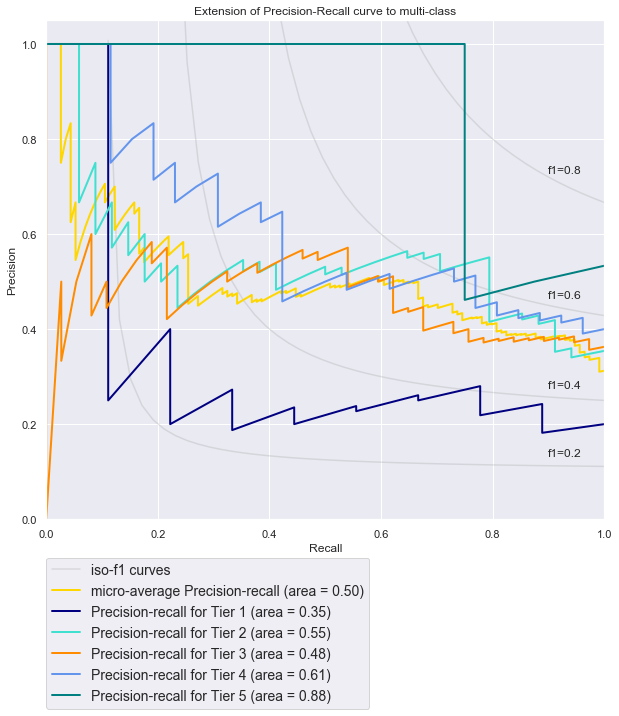

In [213]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(10, 11))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for ' + classes[i] + ' (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Prediction Time!

Now is the moment of truth - applying our model to predict where characters will fall on the tier list. There are currently 18 characters in the game that have not been officially tiered on Gamepress.

In [313]:
preds = pd.DataFrame()
preds["Name"] = totest["Name"]
preds.reset_index(drop = "True")

,Name
0,Bridal Nailah
1,Bridal Oboro
2,Groom Rafiel
3,Bridal Micaiah
4,Groom Hinata


In [314]:
totesta = totest.set_index("Name")
totesta = totesta.drop(["Tier"], axis = 1)
lsvma.predict(totesta)

array(['Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1'], dtype=object)

In [315]:
nsvma.predict(totesta)

array(['Tier 2', 'Tier 2', 'Tier 2', 'Tier 5', 'Tier 4'], dtype=object)

In [316]:
svma.predict(totesta)

array(['Tier 1', 'Tier 1', 'Tier 1', 'Tier 1', 'Tier 1'], dtype=object)

In [317]:
preds["Predictions"] = lsvma.predict(totesta)

In [318]:
preds

,Name,Predictions
176,Bridal Nailah,Tier 1
177,Bridal Oboro,Tier 1
178,Groom Rafiel,Tier 1
179,Bridal Micaiah,Tier 1
523,Groom Hinata,Tier 1


There we have it! Our first set of predictions for our model. Granted, there are still things that we can improve and tinker with for the model, as well as information that can be scraped to give our model more to work with. We will have to wait for some time before we can see how right (or wrong) our model is.

With the data that we scraped and the model that we have created, we can also look to answer other common questions related to rolling characters, such as:

* What is the probability of rolling a particular banner character?
* Is it always worth finishing a roll when you get a five-star?
* I don't have that many orbs. Which banner should I burn my orbs on?

We will save our predictions below to compare with the actual tier listing when they come out on gamepress.

In [319]:
# save predictions 
string = "predictions_" + str(datetime.date(datetime.now()))
preds.to_csv(string, encoding='utf-8', index=False)